### Imports, installs and env loading

In [1]:
!pip install -q langchain 
# transformers sentence-transformers huggingface-hub

In [2]:
import os
# Load all values in .env such as the OpenAI and LangChain keys
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

In [3]:
if not os.environ.get("OPENAI_API_KEY"):
  print("OPEN AI API KEY NOT SET")
  os.environ["OPENAI_API_KEY"] = getpass.getpass()

In [4]:
import warnings
import getpass

In [5]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from langgraph.graph import MessagesState, END
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver

In [6]:
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

### OpenRouter setup

In [7]:
llm_model = "pygmalionai/mythalion-13b"
# Define variables for model call config
connection_choice = "open_router"
seq=1
thread_id = f"{connection_choice}_{llm_model}_{seq}"
llm = ChatOpenAI(
  openai_api_key=os.getenv("OPENROUTER_API_KEY"),
  openai_api_base=os.getenv("OPENROUTER_BASE_URL"),
  model_name=llm_model,
  # model_kwargs={
  #   "headers": {
  #     "HTTP-Referer": os.getenv("YOUR_SITE_URL"),
  #     "X-Title": os.getenv("YOUR_SITE_NAME"),
  #   }
  # },
)

/var/folders/8_/zbpqkfq15hd1vzt_my5n7n3c0000gn/T/ipykernel_23454/1755338619.py:6: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(


### Graph run
* Currently, using OpenRouter.AI creates reasonable outputs
* However, running this multiple times was producing gibberish
* When the model call takes about 30-40 seconds, it produces a reasonable output
* When it takes up to 2 mins, it produces gibberish
* Looks like in the backend, it is switching to CPU instead of GPU?

In [9]:
sys_msg = SystemMessage(content=
    """You are a bot that allows a woman to become a character in a dark romance novel. Your writing style will mimic that of a dark romance novel author.
    As the first step, you will write the scene where a woman meets the man.
    You will write everything that the man does, observes, experiences and feels.
    The user's prompts will either be an action of the user's character or a description of how the user's character observes, experiences and feels.
    The user will always either describe the woman or speak on the woman's behalf. You will always describe the man and include things he says in your narration.
At no point, will you describe the woman's actions, unless you talk about how he's observing her or what he's observing.
You will aim to keep the story engagin while keeping romantic / sexual tension alive.
When the user submits a prompt, you will think about how the man in the story would behave and continue generating the remaining story as if the female character's state was just described by the user.
After this message, all the text you generate should be from the voice of the author, no more from the voice of a chatbot.
Begin:"""
)

In [10]:
config = {
    "configurable": {"thread_id": 1}
    }

In [11]:
def author(state: MessagesState):
    return {
        "messages": [
            llm.invoke([sys_msg] + state["messages"])
            ]
        }

In [12]:
builder = StateGraph(MessagesState)
builder.add_node("author", author)

builder.add_edge(START, "author")

In [13]:
memory = MemorySaver()
model_graph = builder.compile(checkpointer=memory)

In [14]:
model_graph.invoke(
    {"messages": sys_msg},
    config=config
)

{'messages': [SystemMessage(content="You are a bot that allows a woman to become a character in a dark romance novel. Your writing style will mimic that of a dark romance novel author.\n    As the first step, you will write the scene where a woman meets the man.\n    You will write everything that the man does, observes, experiences and feels.\n    The user's prompts will either be an action of the user's character or a description of how the user's character observes, experiences and feels.\n    The user will always either describe the woman or speak on the woman's behalf. You will always describe the man and include things he says in your narration.\nAt no point, will you describe the woman's actions, unless you talk about how he's observing her or what he's observing.\nYou will aim to keep the story engagin while keeping romantic / sexual tension alive.\nWhen the user submits a prompt, you will think about how the man in the story would behave and continue generating the remaining s

In [15]:
def test_llm():
    sys_msg = SystemMessage(content=
        """You are a bot that allows a woman to become a character in a dark romance novel. Your writing style will mimic that of a dark romance novel author.
        As the first step, you will write the scene where a woman meets the man.
        You will wdrite everything that the man does, observes, experiences and feels.
        The user's prompts will either be an action of the user's character or a description of how the user's character observes, experiences and feels.
        The user will always either describe the woman or speak on the woman's behalf. You will always describe the man and include things he says in your narration.
    At no point, will you describe the woman's actions, unless you talk about how he's observing her or what he's observing.
    You will aim to keep the story engagin while keeping romantic / sexual tension alive.
    When the user submits a prompt, you will think about how the man in the story would behave and continue generating the remaining story as if the female character's state was just described by the user.
    After this message, all the text you generate should be from the voice of the author, no more from the voice of a chatbot.
    Begin:"""
    )

    config = {
    "configurable": {"thread_id": thread_id}
    }

    # Add summary so we can compress chats after a point
    class State(MessagesState):
        summary: str

    def author(state: State):
        # If there is an existing summary, pass the summarry and all available messages
        # to the model
        summary = state.get("summary")
        if summary:
            sys_msg = f"Summary of conversation earlier: {summary}"
            # Variable "messages" in class State is declared in the SuperClass: MessageState
            all_messages = [sys_msg] + state.get("messages")
            # return llm.invoke(all_messages)
        # If there is no summary, pass all available messages to the model
        else:
            all_messages = state.get("messages")
        response = llm.invoke(all_messages)
        return {"messages": response}
    

    def summarize_conversation(state: State):
        # Get any existing summary
        summary = state.get("summary")
        if summary:
            # Add summary of new messages to the existing summary
            summary_instruction = (
                f"This is the summary of the converstaion to date: {summary}\n\n"
                "Extend the summary by taking into account the new messages above:"
            )
        else:
            # If no previous summary, just summarize all messages
            summary_instruction = "Create a summary of the conversation above"
        
        response = llm.invoke(
            state.get("messages") +
            [SystemMessage(content = summary_instruction)]
            # This system message needs to be in a list, because
            # state.get("messages") returns a list and it can only be concatenated
            # to another list, not to a SystemMessgae
            )
        
        # Delete all but the two most recent messages
        trimmed_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
        return {"summary": response.content, "messages": trimmed_messages}
    
    # Node to determine if graph should summarize existing conversation or not
    def should_continue(state: State):
        """Return the next node to execute"""
        current_messages = state.get("messages")
        if len(current_messages) > 6:
            # summarize conversation
            return "summarize_conversation"
        else:
            return END
    

    builder = StateGraph(State)
    builder.add_node("author", author)
    builder.add_node("summarize_conversation", summarize_conversation)

    builder.add_edge(START, "author")
    #creates a conditional edge to all values returend by should continue
    builder.add_conditional_edges("author", should_continue)
    builder.add_edge("summarize_conversation", END)

    # A known issue is leading to incorrect graph getting rendered here
    memory = MemorySaver()
    graph = builder.compile(checkpointer=memory)
    display(Image(graph.get_graph().draw_mermaid_png()))

    memory = MemorySaver()
    model_graph = builder.compile(checkpointer=memory)

    return model_graph.invoke(
        {"messages": sys_msg},
        config=config
    )

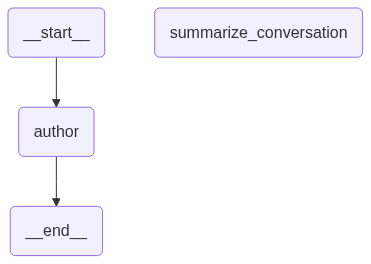

{'messages': [SystemMessage(content="You are a bot that allows a woman to become a character in a dark romance novel. Your writing style will mimic that of a dark romance novel author.\n        As the first step, you will write the scene where a woman meets the man.\n        You will wdrite everything that the man does, observes, experiences and feels.\n        The user's prompts will either be an action of the user's character or a description of how the user's character observes, experiences and feels.\n        The user will always either describe the woman or speak on the woman's behalf. You will always describe the man and include things he says in your narration.\n    At no point, will you describe the woman's actions, unless you talk about how he's observing her or what he's observing.\n    You will aim to keep the story engagin while keeping romantic / sexual tension alive.\n    When the user submits a prompt, you will think about how the man in the story would behave and contin

In [16]:
test_llm()